In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools as ft
import statsmodels.api as sm
import scipy as sc
import statsmodels.stats.api as sms
import statsmodels.discrete.discrete_model as smdiscrete

import warnings
warnings.filterwarnings('ignore')

In [6]:
portf = pd.read_excel('Industry_Portfolios_excess.xlsx')
risk_factors = pd.read_excel('Risk_Factors.xlsx')
excess_ind = portf.drop(['Date'], axis=1)

In [7]:
# Let's look at dataframes

display(excess_ind.head(), risk_factors.head())

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,-0.01,-1.14,-0.69,0.37,4.46,1.34,0.38,3.02,1.85,2.81
1,4.19,-0.13,1.89,4.63,-2.98,-0.58,6.03,0.83,2.01,2.10
2,-0.18,-1.24,-0.36,-0.22,-2.64,-2.16,0.20,-4.05,1.04,-0.72
3,1.34,2.22,-0.25,2.44,-4.99,-0.56,-2.78,3.46,-3.63,-3.84
4,-1.95,-1.70,1.55,0.33,4.79,-3.01,0.24,-0.48,1.22,1.80


,Date,Rf,Rm-Rf,SMB,HML
0,200401,0.07,2.15,2.67,1.55
1,200402,0.06,1.40,-1.17,0.45
2,200403,0.09,-1.32,1.84,0.07
3,200404,0.08,-1.83,-2.59,-1.67
4,200405,0.06,1.17,-0.10,-0.33


In [8]:
# let's find sharpe - mean excess returns by stdev
#risk_free_rate = 0.13

#excess_ind = portf.drop(['Date', 'Market'], axis=1)
#excess_ind = excess_ind.sub(risk_free_rate, axis='columns') #substract the risk_free_rate

In [9]:
mean_returns = excess_ind.mean()
stdev = excess_ind.std()

sharpe = pd.DataFrame(mean_returns / stdev, columns=['Sharpe'])

sharpe

,Sharpe
NoDur,0.231099
Durbl,0.072356
Manuf,0.166616
Enrgy,0.181708
HiTec,0.118552
Telcm,0.169064
Shops,0.191753
Hlth,0.172529
Utils,0.210948
Other,0.064693


In [10]:
# let's find treynor = mean excess returns by capm beta 

def derive_coef(df, s):
    coeffs = pd.DataFrame(index = ['α', 'β'])
    x = np.array(s).reshape(-1, 1)
    x = sm.add_constant(x)
    for col in df.columns:
        y = np.array(df[col])
        model = sm.OLS(y, x)
        results = model.fit()
        coeffs[col] = results.params.tolist()
    return coeffs

treynorb = derive_coef(excess_ind, risk_factors['Rm-Rf'])
treynor_r = mean_returns / treynorb.loc['β']
treynor = pd.DataFrame(treynor_r)
treynor.reset_index(drop=True)
treynor.rename(columns={treynor.columns[0]:'Treynor'}, inplace=True)

treynor

,Treynor
NoDur,1.186372
Durbl,0.367463
Manuf,0.758251
Enrgy,1.143330
HiTec,0.564295
Telcm,0.836363
Shops,0.951258
Hlth,0.971435
Utils,1.452334
Other,0.299781


In [11]:
#let's find sortino - mean excess returns by sqrt of semivar. semivar is 1/sample sie*sigma sum(min from excess r and 0)^2)  

def calc_semivar (df):
    size = len(df)
    semivar = df.copy()
    semivar[semivar < 0] = 0
    semivar = (semivar**2).agg('sum') / size
    return semivar

forsortino = calc_semivar(excess_ind)
sortino_r = mean_returns / (forsortino)**0.5
sortino = pd.DataFrame(sortino_r)
sortino.reset_index(drop=True)
sortino.rename(columns={sortino.columns[0]:'Sortino'}, inplace=True)

sortino

,Sortino
NoDur,0.295626
Durbl,0.095065
Manuf,0.226216
Enrgy,0.237849
HiTec,0.163941
Telcm,0.229255
Shops,0.247506
Hlth,0.220180
Utils,0.296199
Other,0.096724


In [12]:
# let's find jensen's alpha

alpha = treynorb.loc['α']
j_alpha = pd.DataFrame(alpha)

j_alpha

,α
NoDur,0.369717
Durbl,-0.417903
Manuf,0.160494
Enrgy,0.504485
HiTec,-0.064024
Telcm,0.194348
Shops,0.274093
Hlth,0.236968
Utils,0.446523
Other,-0.387508


In [13]:
ratios = pd.concat([j_alpha, sharpe, treynor, sortino], axis=1)
ratios.index.name = 'Industry'

ratios

,α,Sharpe,Treynor,Sortino
Industry,,,,
NoDur,0.369717,0.231099,1.186372,0.295626
Durbl,-0.417903,0.072356,0.367463,0.095065
Manuf,0.160494,0.166616,0.758251,0.226216
Enrgy,0.504485,0.181708,1.143330,0.237849
HiTec,-0.064024,0.118552,0.564295,0.163941
Telcm,0.194348,0.169064,0.836363,0.229255
Shops,0.274093,0.191753,0.951258,0.247506
Hlth,0.236968,0.172529,0.971435,0.220180
Utils,0.446523,0.210948,1.452334,0.296199


In [14]:
# let's find 3 factor alpha

results = []

for industry in excess_ind:
# Loop through each industry portfolio and perform linear regression
    Y = excess_ind[industry]  # Excess returns for the industry portfolio
    X = risk_factors[['Rm-Rf', 'SMB', 'HML']]  # 3 components in risk factors
    X = sm.add_constant(X)  # Add a constant term for the intercept (α)

    # Fit the linear regression model
    model = sm.OLS(Y, X).fit()

    # Extract the intercept (α) and slope coefficient (β)
    alpha = model.params['const']
    beta_3f = model.params['Rm-Rf']
    gamma_3f = model.params['SMB']
    delta_3f = model.params['HML']

    # Append the results to the list
    results.append({'Industry': industry, 'Alpha_3f': alpha, 'Beta_3f': beta_3f, 'Gamma_3f': gamma_3f , 'Delta_3f': delta_3f})

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df

,Industry,Alpha_3f,Beta_3f,Gamma_3f,Delta_3f
0,NoDur,0.386704,0.712134,-0.229102,-0.023342
1,Durbl,-0.474342,1.447452,0.670878,0.240949
2,Manuf,0.153285,1.142282,0.087388,0.027727
3,Enrgy,0.523007,1.028354,-0.259360,-0.008158
4,HiTec,-0.065979,1.152803,0.335674,-0.556947
5,Telcm,0.200724,0.924137,-0.080299,-0.019063
6,Shops,0.255941,0.770227,0.280191,-0.039080
7,Hlth,0.257472,0.751976,-0.212655,-0.143765
8,Utils,0.474411,0.631827,-0.387961,-0.016881
9,Other,-0.404412,1.123473,-0.061676,0.547325


In [15]:
famafr = results_df.iloc[:,[0, 1]].set_index('Industry')

In [16]:
summary = pd.concat([famafr, ratios], axis=1).reset_index()
summary

,Industry,Alpha_3f,α,Sharpe,Treynor,Sortino
0,NoDur,0.386704,0.369717,0.231099,1.186372,0.295626
1,Durbl,-0.474342,-0.417903,0.072356,0.367463,0.095065
2,Manuf,0.153285,0.160494,0.166616,0.758251,0.226216
3,Enrgy,0.523007,0.504485,0.181708,1.143330,0.237849
4,HiTec,-0.065979,-0.064024,0.118552,0.564295,0.163941
5,Telcm,0.200724,0.194348,0.169064,0.836363,0.229255
6,Shops,0.255941,0.274093,0.191753,0.951258,0.247506
7,Hlth,0.257472,0.236968,0.172529,0.971435,0.220180
8,Utils,0.474411,0.446523,0.210948,1.452334,0.296199
9,Other,-0.404412,-0.387508,0.064693,0.299781,0.096724


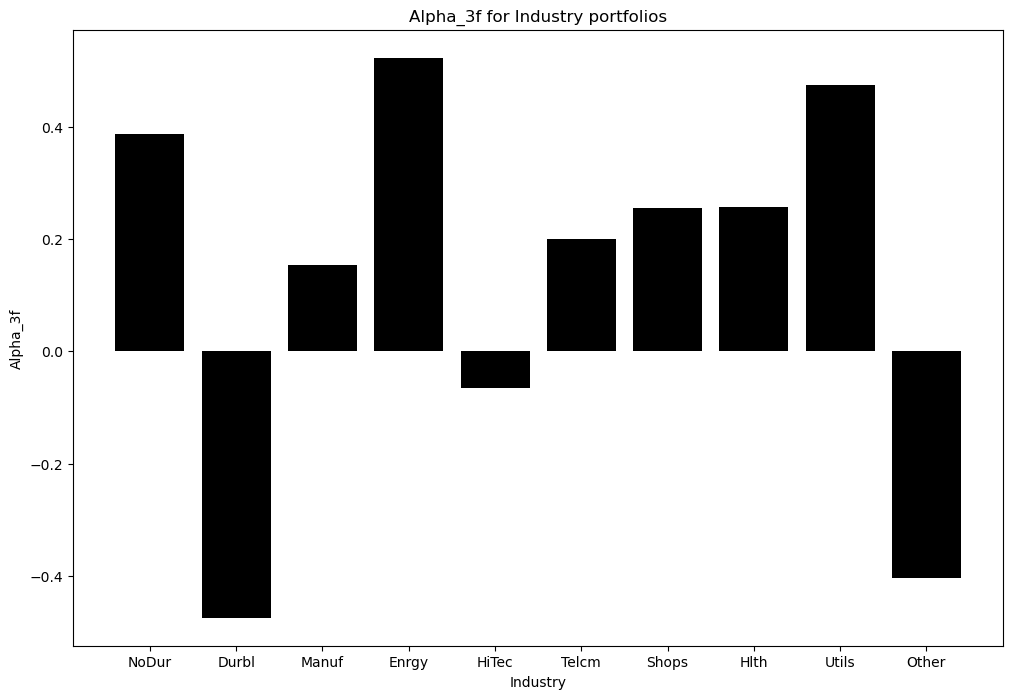

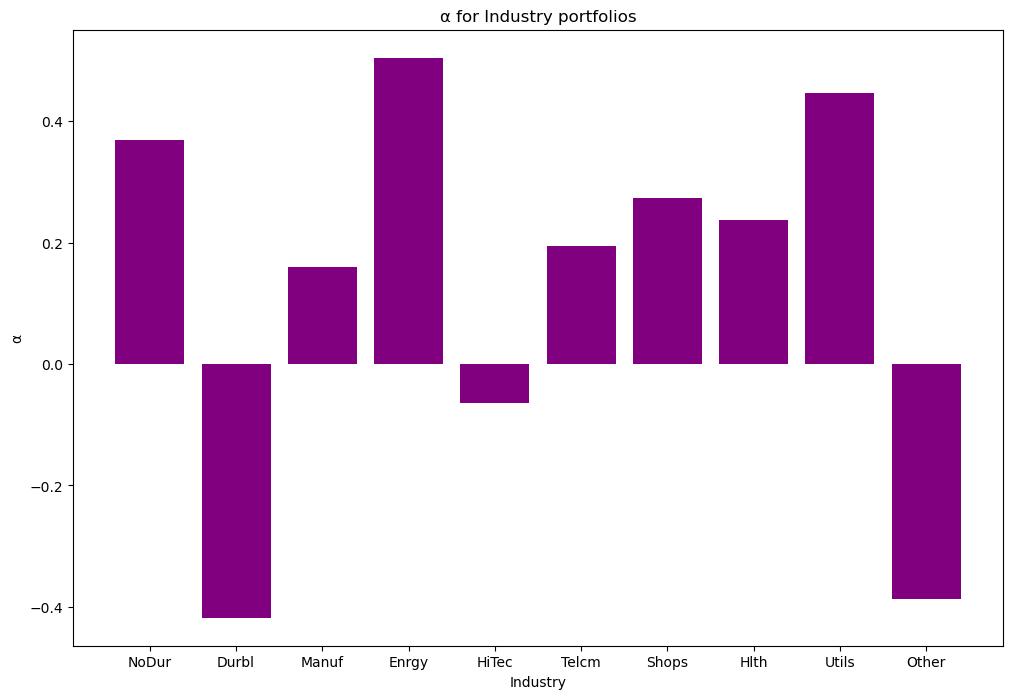

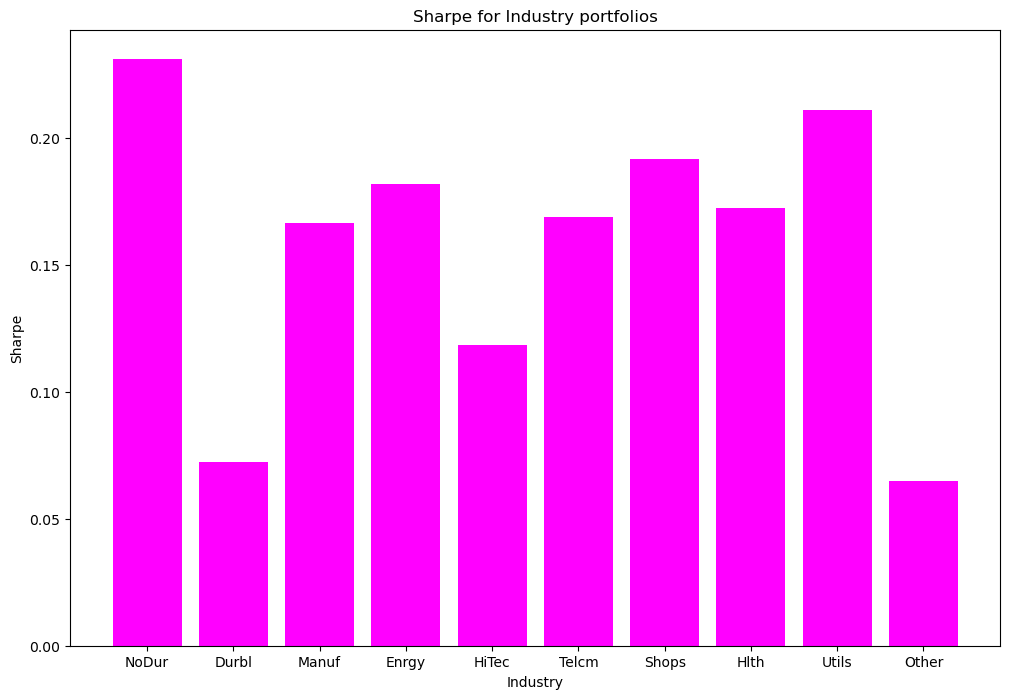

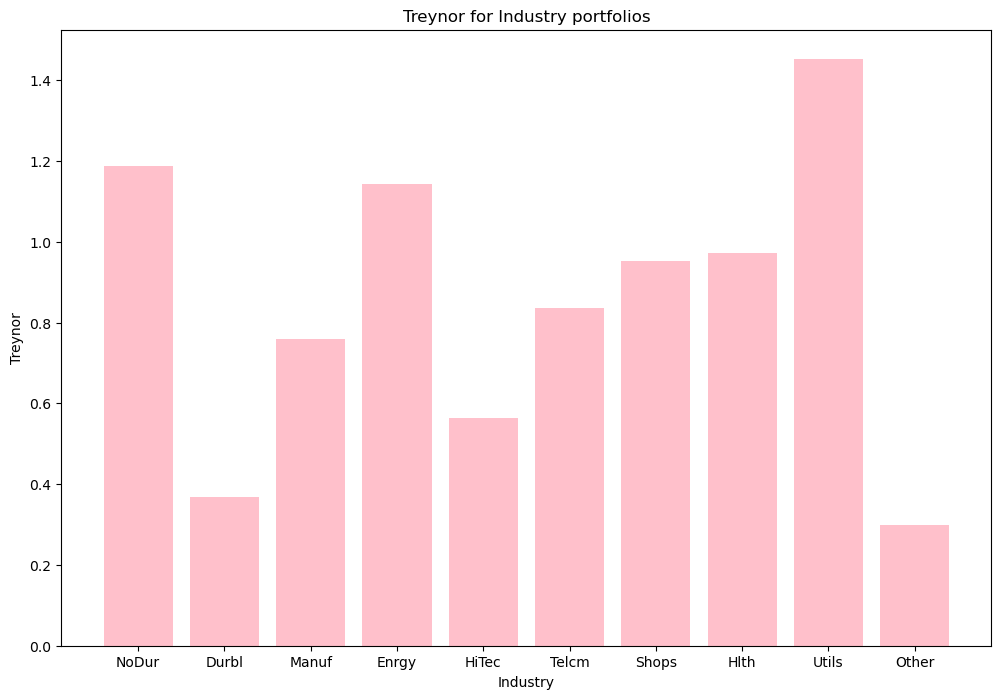

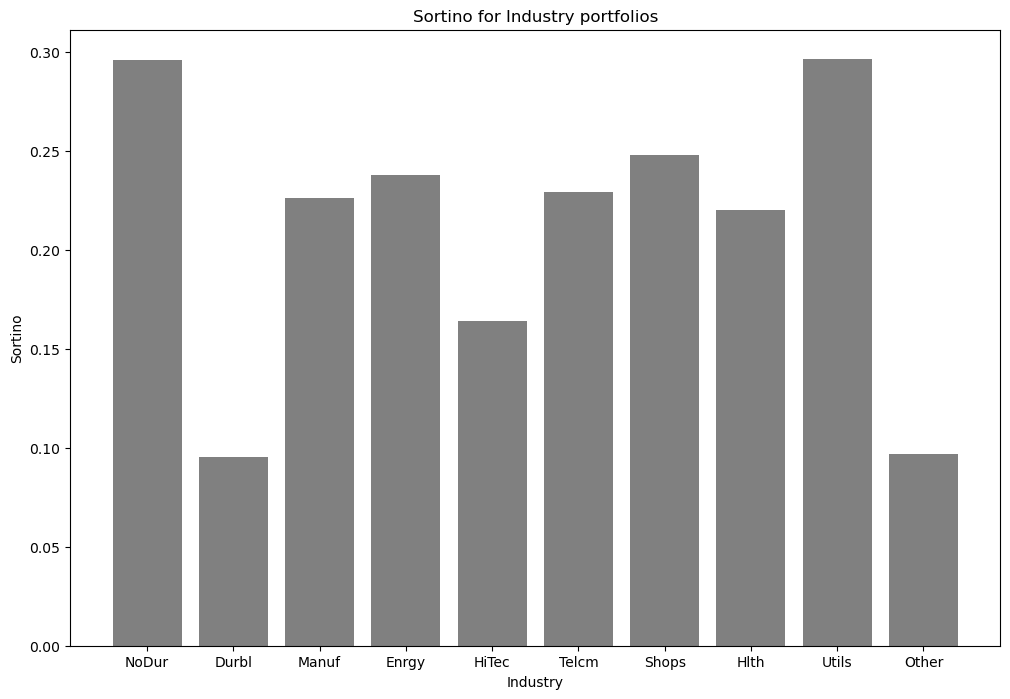

In [17]:
ratios_colors = {
                'Alpha_3f': 'black',
                'α': 'purple',
                'Sharpe': 'magenta',
                'Treynor': 'pink',
                'Sortino': 'grey'
                }

for col in ratios_colors:
    plt.figure(figsize=(12, 8))
    bars = plt.bar(summary['Industry'], summary[col], color=ratios_colors[col])
    plt.xlabel('Industry')
    plt.ylabel(col)
    plt.title(f'{col} for Industry portfolios')
    plt.show()

Sharpe ratio captures all risk, both idiosyncratic and market, what gives a fuller picture in terms of risk but on the other hand makes it hard to compare diversified and non-diversified portfolios. Moreover, since Sharpe ratio is basically excess returns' mean divided by standard deviation, it does not take into account higher moments such as skewness or kurtosis, which are also crucial for comparison, as in real life returns are usually not normally distributed. Portfolio NoDur has the highest - the best - Sharpe ratio.

Treynor ratio reflects the amount of risk premium paid for each unit of market risk and is excess returns divided by beta (sensitivity to market risk). From one point of view, this ratio could allow us to compare different assets and portfolios better than Sharpe's, but in fact Treynor ratio ignores other types of risk (e.g. industry risk)
Portfolio Utils has the highest Treynor ratio, which means that it has a higher risk premium payable when it comes to market risk.

Sortino ratio takes into account not the premiums, but potential losses (downside risk) - it is calculated as expected deviation from target return divided by below-target semi-deviation. This makes the ratio more 'realistic' because it works well also on those distributions that are not normal. NoDur has the highest Sortino ratio, which means that within the timeframe the risks for investing in this industry portfolio will be well paid off.